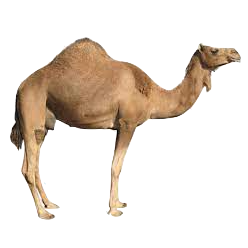

In [1]:
from IPython.display import Image as Image_colab
from IPython.display import display
from PIL import Image
import os

def mInput(prompt, default=None):
    prompt = f"{prompt} [{default}]: " if default else f"{prompt}: "
    response = input(prompt)
    return response if response else default

target_image = mInput("Image name:",default="camel.png")
abs_path = os.path.abspath(os.getcwd())
target_ = f"{abs_path}/target_images/{target_image}"
img_ = Image_colab(target_)
display(img_)

Processing [camel.png] ...


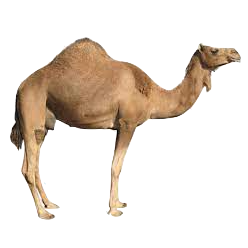

GPU: True, 0


In [2]:
import torch
gpunum=0

os.environ["CUDA_VISIBLE_DEVICES"] = ','.join([f"{gpunum}"])
print("=" * 50)
print(f"Processing [{target_image}] ...")
img_ = Image_colab(target_)
display(img_)
print(f"GPU: {torch.cuda.is_available()}, {torch.cuda.current_device()}")
print("=" * 50)

In [3]:
seeds = 1001

from painterly_rendering import *

sys.argv = ['painterly_rendering.py', 'D:\\code\\CLIPasso/target_images/camel.png', '--num_paths', '16', '--output_dir', 'D:\\code\\CLIPasso/output_sketches/camel/', '--wandb_name', 'camel_16strokes_seed0', '--num_iter', '2001', '--save_interval', '10', '--seed', '0', '--use_gpu', '1', '--fix_scale', '0', '--mask_object', '0', '--mask_object_attention', '0', '--display_logs', '0', '--display', '0']

args = config.parse_arguments()
final_config = vars(args)

loss_func = Loss(args)
inputs, mask = get_target(args)

utils.log_input(args.use_wandb, 0, inputs, args.output_dir)
renderer = load_renderer(args, inputs, mask)

optimizer = PainterOptimizer(args, renderer)
counter = 0
configs_to_save = {"loss_eval": []}
best_loss, best_fc_loss = 100, 100
best_iter, best_iter_fc = 0, 0
min_delta = 1e-5
terminate = False

renderer.set_random_noise(0)
img = renderer.init_image(stage=0)
optimizer.init_optimizers()

if args.display:
    epoch_range = range(args.num_iter)
else:
    epoch_range = tqdm(range(args.num_iter))

for epoch in epoch_range:
    print(f"Epoch: {epoch}/{args.num_iter}")
    if not args.display:
        epoch_range.refresh()
    renderer.set_random_noise(epoch)
    if args.lr_scheduler:
        optimizer.update_lr(counter)

    start = time.time()
    optimizer.zero_grad_()
    sketches = renderer.get_image().to(args.device)
    losses_dict = loss_func(sketches, inputs.detach(
    ), renderer.get_color_parameters(), renderer, counter, optimizer)
    loss = sum(list(losses_dict.values()))
    loss.backward()
    optimizer.step_()
    if epoch % args.save_interval == 0:
        utils.plot_batch(inputs, sketches, f"{args.output_dir}/jpg_logs", counter,
                            use_wandb=args.use_wandb, title=f"iter{epoch}.jpg")
        renderer.save_svg(
            f"{args.output_dir}/svg_logs", f"svg_iter{epoch}")
    if epoch % args.eval_interval == 0:
        with torch.no_grad():
            losses_dict_eval = loss_func(sketches, inputs, renderer.get_color_parameters(
            ), renderer.get_points_parans(), counter, optimizer, mode="eval")
            loss_eval = sum(list(losses_dict_eval.values()))
            configs_to_save["loss_eval"].append(loss_eval.item())
            for k in losses_dict_eval.keys():
                if k not in configs_to_save.keys():
                    configs_to_save[k] = []
                configs_to_save[k].append(losses_dict_eval[k].item())
            if args.clip_fc_loss_weight:
                if losses_dict_eval["fc"].item() < best_fc_loss:
                    best_fc_loss = losses_dict_eval["fc"].item(
                    ) / args.clip_fc_loss_weight
                    best_iter_fc = epoch
            # print(
            #     f"eval iter[{epoch}/{args.num_iter}] loss[{loss.item()}] time[{time.time() - start}]")

            cur_delta = loss_eval.item() - best_loss
            if abs(cur_delta) > min_delta:
                if cur_delta < 0:
                    best_loss = loss_eval.item()
                    best_iter = epoch
                    terminate = False
                    utils.plot_batch(
                        inputs, sketches, args.output_dir, counter, use_wandb=args.use_wandb, title="best_iter.jpg")
                    renderer.save_svg(args.output_dir, "best_iter")

            if args.use_wandb:
                wandb.run.summary["best_loss"] = best_loss
                wandb.run.summary["best_loss_fc"] = best_fc_loss
                wandb_dict = {"delta": cur_delta,
                                "loss_eval": loss_eval.item()}
                for k in losses_dict_eval.keys():
                    wandb_dict[k + "_eval"] = losses_dict_eval[k].item()
                wandb.log(wandb_dict, step=counter)

            if abs(cur_delta) <= min_delta:
                if terminate:
                    break
                terminate = True

    if counter == 0 and args.attention_init:
        utils.plot_atten(renderer.get_attn(), renderer.get_thresh(), inputs, renderer.get_inds(),
                            args.use_wandb, "{}/{}.jpg".format(
                                args.output_dir, "attention_map"),
                            args.saliency_model, args.display_logs)

    if args.use_wandb:
        wandb_dict = {"loss": loss.item(), "lr": optimizer.get_lr()}
        for k in losses_dict.keys():
            wandb_dict[k] = losses_dict[k].item()
        wandb.log(wandb_dict, step=counter)

    counter += 1





  0%|          | 0/2001 [00:00<?, ?it/s]

Epoch: 0/2001
Epoch: 1/2001
Epoch: 2/2001
Epoch: 3/2001
Epoch: 4/2001
Epoch: 5/2001
Epoch: 6/2001
Epoch: 7/2001
Epoch: 8/2001
Epoch: 9/2001
Epoch: 10/2001
Epoch: 11/2001
Epoch: 12/2001
Epoch: 13/2001
Epoch: 14/2001
Epoch: 15/2001
Epoch: 16/2001
Epoch: 17/2001
Epoch: 18/2001
Epoch: 19/2001
Epoch: 20/2001
Epoch: 21/2001
Epoch: 22/2001
Epoch: 23/2001
Epoch: 24/2001
Epoch: 25/2001
Epoch: 26/2001
Epoch: 27/2001
Epoch: 28/2001
Epoch: 29/2001
Epoch: 30/2001
Epoch: 31/2001
Epoch: 32/2001
Epoch: 33/2001
Epoch: 34/2001
Epoch: 35/2001
Epoch: 36/2001
Epoch: 37/2001
Epoch: 38/2001
Epoch: 39/2001
Epoch: 40/2001
Epoch: 41/2001
Epoch: 42/2001
Epoch: 43/2001
Epoch: 44/2001
Epoch: 45/2001
Epoch: 46/2001
Epoch: 47/2001
Epoch: 48/2001
Epoch: 49/2001
Epoch: 50/2001
Epoch: 51/2001
Epoch: 52/2001
Epoch: 53/2001
Epoch: 54/2001
Epoch: 55/2001
Epoch: 56/2001
Epoch: 57/2001
Epoch: 58/2001
Epoch: 59/2001
Epoch: 60/2001
Epoch: 61/2001
Epoch: 62/2001
Epoch: 63/2001
Epoch: 64/2001
Epoch: 65/2001
Epoch: 66/2001
Epoch

In [16]:
print(renderer.render_warp().shape)

for points in renderer.control_points_set:
    for point in points:
        if point[0] > 224 or point[1] > 224:
            print(point)

torch.Size([224, 224, 4])
tensor([251.7066,  58.2013], device='cuda:0', grad_fn=<UnbindBackward0>)
tensor([246.6214,  71.6036], device='cuda:0', grad_fn=<UnbindBackward0>)
tensor([271.2713,  43.6202], device='cuda:0', grad_fn=<UnbindBackward0>)


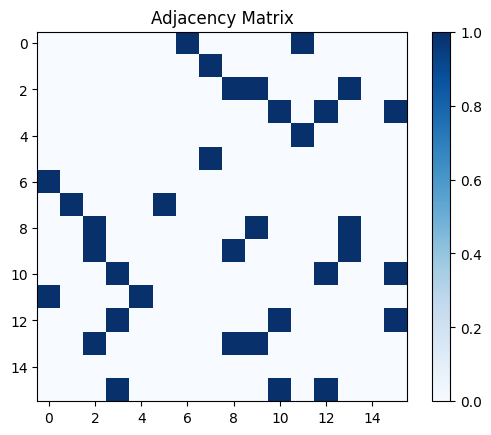

In [17]:
import torch
import matplotlib.pyplot as plt

#learnable parameters
similar_threshold = 0.7
attention_threshold = 0.2


def computeCosineSimilarity(pointA: torch.Tensor, pointB: torch.Tensor):
    # 计算两个向量的余弦相似度
    dot_product = torch.dot(pointA, pointB)
    normA = torch.norm(pointA)
    normB = torch.norm(pointB)
    return dot_product / (normA * normB + 1e-8)

def computePointsCosineSimilarity(pointsA: torch.Tensor, pointsB: torch.Tensor):
    assert len(pointsA) == len(pointsB)
    n = len(pointsA)
    
    # 对集合进行排序，按照第一维
    pointsA = pointsA[pointsA[:, 0].argsort()]
    pointsB = pointsB[pointsB[:, 0].argsort()]

    # 差分
    diffA = pointsA[1:] - pointsA[:-1]
    diffB = pointsB[1:] - pointsB[:-1]

    # 计算余弦相似度
    cosine_sim = torch.tensor([computeCosineSimilarity(diffA[i], diffB[i]) for i in range(n-1)])

    return cosine_sim.mean()

def getAttention(point: torch.Tensor):
    # assert point[1] < renderer.attention_map.shape[0] and point[0] < renderer.attention_map.shape[1]
    if point[1] >= renderer.attention_map.shape[0] or point[0] >= renderer.attention_map.shape[1]:
        return torch.tensor(0.0)
    return renderer.attention_map[point[1].long(), point[0].long()]

def computeAttentionSimilarity(pointsA: torch.Tensor, pointsB: torch.Tensor):
    assert len(pointsA) == len(pointsB)
    n = len(pointsA)
    
    attention_A = torch.tensor([getAttention(point) for point in pointsA])
    attention_B = torch.tensor([getAttention(point) for point in pointsB])

    return abs(attention_A.mean() - attention_B.mean())

def computeAdjacencyMatrix(points_set):
    num_points = len(points_set)
    adjacency_matrix = torch.zeros((num_points, num_points), dtype=torch.float32)
    for i in range(len(points_set)):
        for j in range(len(points_set)):
            if i == j:
                continue
            cos_sim = computePointsCosineSimilarity(points_set[i], points_set[j])
            att_sim = computeAttentionSimilarity(points_set[i], points_set[j])
            # print(f"cos_sim: {cos_sim}, att_sim: {att_sim}")
            adjacency_matrix[i, j] = torch.where(cos_sim > similar_threshold and att_sim < attention_threshold, torch.tensor(1.0), torch.tensor(0.0))
    return adjacency_matrix

adjacency_matrix = computeAdjacencyMatrix(renderer.control_points_set).to('cuda')

plt.imshow(adjacency_matrix.cpu().numpy(), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Adjacency Matrix')
plt.show()

feature_matrix = torch.stack(renderer.control_points_set)
# feature_matrix = feature_matrix.view(16,-1).to('cuda')

In [16]:
print(renderer.shape_groups.__sizeof__())
print(renderer.shapes.__sizeof__())

168
168


In [22]:
import matplotlib.pyplot as plt
import pydiffvg
import os
import glob


def clear_directory(directory, file_extension="*.png"):
    if not os.path.exists(directory):
        os.makedirs(directory)
    else:
        # 获取目录下所有指定扩展名的文件
        files = glob.glob(os.path.join(directory, file_extension))
        for file in files:
            try:
                os.remove(file)  # 删除文件
            except Exception as e:
                print(f"Error deleting file {file}: {e}")

clear_directory("./saved_img")

def find_connected_components(adj_matrix: torch.Tensor):
    num_nodes = adj_matrix.size(0)
    visited = torch.zeros(num_nodes, dtype=torch.bool, device=adj_matrix.device)
    components = []

    def bfs(start_node):
        queue = [start_node]
        component = []
        while queue:
            node = queue.pop(0)
            if not visited[node]:
                visited[node] = True
                component.append(node)
                neighbors = (adj_matrix[node] > 0).nonzero(as_tuple=True)[0]
                queue.extend(neighbors.cpu().tolist())
        return component

    for node in range(num_nodes):
        if not visited[node]:
            components.append(bfs(node))

    return components

canvas_width, canvas_height = renderer.attention_map.shape
pydiffvg.set_use_gpu(torch.cuda.is_available())

connected_components = find_connected_components(adjacency_matrix)
connected_components = [list(map(int, comp)) for comp in connected_components]

num_control_points = torch.zeros(renderer.num_segments, dtype = torch.int32) + (renderer.control_points_per_seg - 2)
for group_id, component in enumerate(connected_components):
    # 确定子图网格大小
    num_paths = len(component)
    cols = 4  # 每行显示的图像数
    rows = (num_paths + cols - 1) // cols  # 计算需要的行数
    
    # 创建子图
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()  # 将二维数组展平成一维，便于遍历
    for idx, i in enumerate(component):
        points = renderer.control_points_set[i]
        
        path = pydiffvg.Path(num_control_points=num_control_points,
                             points=points,
                             stroke_width=torch.tensor(1),
                             is_closed=False)
        shapes = [path]
        path_group = pydiffvg.ShapeGroup(shape_ids=torch.tensor([0]),
                                         fill_color=None,
                                         stroke_color=torch.tensor([0.0, 0.0, 0.0, 1.0]))
        shape_groups = [path_group]
        scene_args = pydiffvg.RenderFunction.serialize_scene(
            canvas_width, canvas_height, shapes, shape_groups
        )
        render = pydiffvg.RenderFunction.apply
        out = render(canvas_width, canvas_height, 2, 2, 0, None, *scene_args)
        
        # 在子图中绘制当前 path
        axes[idx].imshow(out.cpu().detach().numpy(), interpolation="nearest")
        # axes[idx].axis("off")
        axes[idx].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        axes[idx].set_title(f"Path {i}")

        for spine in axes[idx].spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)
    
    # 隐藏多余的子图
    for ax in axes[num_paths:]:
        ax.axis("off")
    
    # 保存当前组的图像
    plt.tight_layout()
    plt.savefig(f"./saved_img/group_{group_id}.png")
    plt.close()

print(f"Generated {len(connected_components)} group images.")


Generated 5 group images.


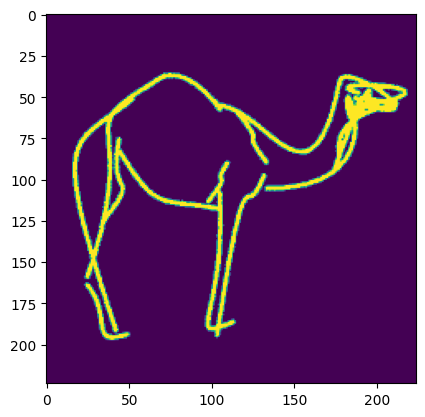

In [9]:
import pydiffvg
import matplotlib.pyplot as plt
canvas_width, canvas_height = renderer.attention_map.shape[0],renderer.attention_map.shape[1]
pydiffvg.set_use_gpu(torch.cuda.is_available())
scene_args = pydiffvg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, renderer.shapes, renderer.shape_groups)
render = pydiffvg.RenderFunction.apply
out = render(canvas_width, # width
             canvas_height, # height
             2,   # num_samples_x
             2,   # num_samples_y
             0,   # seed
             None,
             *scene_args)

plt.figure()

# atm = renderer.attention_map
# atm_tensor = torch.tensor(atm, device='cuda', dtype=torch.float32)
# 访问 out 的每个像素
# print(out.shape)
# 输出 (224,224,1)的值
# print(out[:,:,3])

# out[:, :, 3] = torch.where(out[:, :, 3] > 0, atm_tensor, out[:, :, 3])

plt.imshow(out[:,:,3].cpu().detach().numpy(),cmap='viridis')




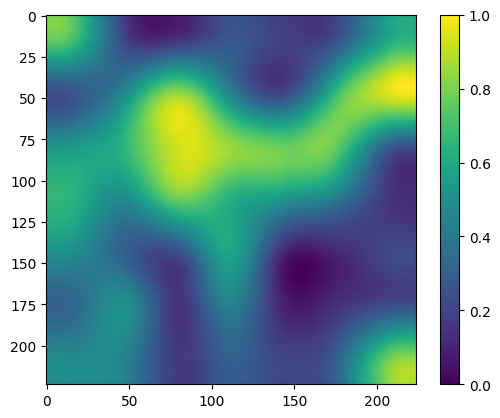

[[0.7972916  0.80018055 0.80258805 ... 0.61528736 0.6138429  0.61191696]
 [0.79969907 0.80258805 0.8049955  ... 0.6138429  0.61239845 0.61047244]
 [0.80210656 0.8049955  0.80740297 ... 0.61239845 0.610954   0.609028  ]
 ...
 [0.49395126 0.49443275 0.49443275 ... 0.88636774 0.8844418  0.8815528 ]
 [0.49346974 0.49346974 0.49395126 ... 0.8839603  0.8820343  0.8791453 ]
 [0.49250677 0.49298826 0.49298826 ... 0.8810713  0.87866384 0.8762564 ]]


In [7]:
import matplotlib.pyplot as plt

plt.imshow(renderer.attention_map,cmap='viridis')
plt.colorbar()
plt.show()
print(renderer.attention_map)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gcn

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = gcn.GCNConv(in_channels, hidden_channels)
        self.conv2 = gcn.GCNConv(hidden_channels, out_channels)
        self.linear = nn.Linear(out_channels, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = self.linear(x)
        return x

def graph_structure_loss(features, adjacency_matrix):
    cosine_sim = F.cosine_similarity(features.unsqueeze(1), features.unsqueeze(0), dim=-1)

    structure_loss = torch.sum(adjacency_matrix * (1 - cosine_sim)) / adjacency_matrix.sum()
    return structure_loss

Gmodel = GCN(8, 16, 8).to('cuda')

optimizer = torch.optim.Adam(Gmodel.parameters(), lr=0.0001)

num_epochs = 100
for epoch in range(num_epochs):
    Gmodel.train()
    optimizer.zero_grad()

    out = Gmodel(feature_matrix, adjacency_matrix)

    structure_loss = graph_structure_loss(out, adjacency_matrix)

    loss = torch.mean(torch.sum(out ** 2, dim=1)) + 0.1 * structure_loss  

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Gmodel.eval()


Epoch 0, Loss: 2267549.25
Epoch 10, Loss: 2167677.0
Epoch 20, Loss: 2071566.875
Epoch 30, Loss: 1979324.5
Epoch 40, Loss: 1890855.0
Epoch 50, Loss: 1806030.875
Epoch 60, Loss: 1724705.75
Epoch 70, Loss: 1646726.125
Epoch 80, Loss: 1571947.75
Epoch 90, Loss: 1500235.75


GCN(
  (conv1): GCNConv()
  (conv2): GCNConv()
  (linear): Linear(in_features=8, out_features=2, bias=True)
)

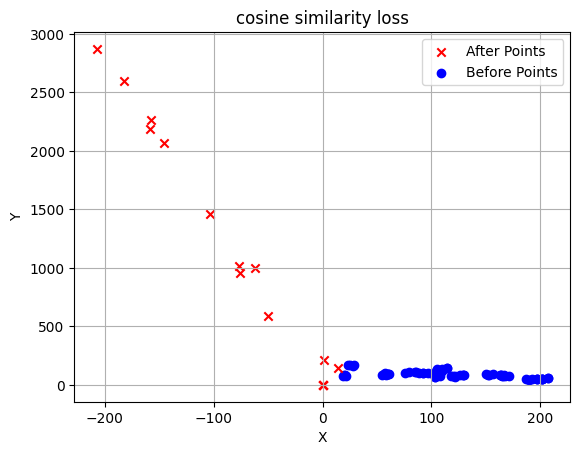

In [25]:
for points in renderer.control_points_set:
    # 每个点集有 4 个点，分别提取这些点的坐标
    x_coords = points[:, 0].cpu().numpy()  # x 坐标
    y_coords = points[:, 1].cpu().numpy()  # y 坐标

    # 使用不同颜色或标记绘制每个点集
    plt.scatter(x_coords, y_coords, color='blue', marker='o')  # 用圆形表示之前的点
with torch.no_grad():
    out = Gmodel(feature_matrix, adjacency_matrix)
    #control points set
    x_af = out[:, 0].cpu().numpy()
    y_af = out[:, 1].cpu().numpy()

plt.scatter(x_af,y_af, color='red', marker='x', label="After Points")
plt.scatter(x_coords, y_coords, color='blue', marker='o', label="Before Points")
plt.xlabel('X')
plt.ylabel('Y')
# 显示图例
plt.legend()

# 显示网格
plt.grid(True)
plt.title('cosine similarity loss')

# 显示图形
plt.show()